# SCI6485 Introduction to Generative Artificial Intelligence

##  CNN classifier


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

# Introduction


In this tutorial, we will learn how to use Pytorch to train a simple CNN classifier. We will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

If you want to learn more about the dataset, please refer to: https://www.cs.toronto.edu/~kriz/cifar.html

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Visualize the loss graph
6. Test the network on the test data
7. Data augmentation & retrain the model



# How to use this colab
1. You should be able to run all the code cell by cell without any bugs.
2. The green texts with a `#` in the front of the line are comments/explanation for the code below it. You could delete all the comments if you don't need it.
3. To quickly jump to the part you want read, you can use the table of contents feature on the left-hand sidebar.

# 0. Import torch and check your devices

In [ ]:
import torch

# make the code reproducible
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

You may choose to use GPU runtime type to the model.
Let's first ask Pytorch to detect whether you have an available GPU and if yes, we could use it to train the model.


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## 1. Load and normalize CIFAR10

Using ``torchvision`` to download CIFAR10 data

In [ ]:
import torchvision
import torchvision.transforms as transforms

The code below will download the CIFAR10 dataset to your colab. The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

Warining: if you disconnect your colab runtime, the downloaded files will be gone and you have to rerun this code to download them again. We will introduce a way to connect your colab with your google drive so that you could save data in your google drive.



In [ ]:
# set the transform function
transform = transforms.Compose([
                              transforms.ToTensor(),
                              # The first tuple (0.5, 0.5, 0.5) represents the mean values for each channel (red, green, and blue)
                              # the second tuple (0.5, 0.5, 0.5) represents the standard deviation values for each channel
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])


batch_size = 32

# get training dataset and save the image to your colab root directory
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# get testing dataset and save the image to your colab root directory
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# subset_size = 20000
# # Create a random sampler to select a subset of the dataset
# subset_sampler = torch.utils.data.RandomSampler(trainset, num_samples=subset_size, replacement=False)

# # Use a DataLoader with the sampler to load the subset
# subset_loader = torch.utils.data.DataLoader(subset_sampler, batch_size=batch_size, sampler=subset_sampler)

# class order matters!
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 88187077.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Check how many data points we have in the training and testing datasets. The training set consists of 50000 images, with 5000 of each class. The test set consists of 10000 images with 1000 for each class.

In [ ]:
print(len(trainset))
print(len(testset))

50000
10000


Visualize some images and classes


torch.Size([32, 3, 32, 32])


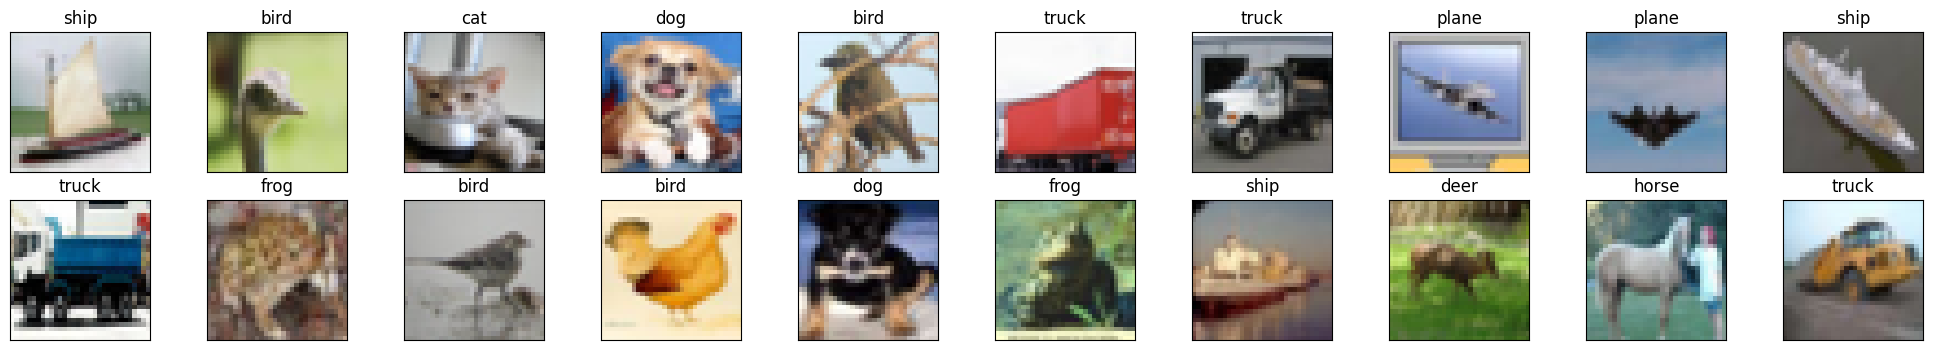

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def im_convert(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    return image

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# check batch size
print(images.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])


## 2. Define a Convolutional Neural Network
We define the architecture of a neural network with 2 convolutional layers and several fully connected layers. The model will take 3-channel images as the input.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# This line defines a new Python class named Net, which is a neural network model
# It inherits from the nn.Module class, which is a base class for all PyTorch neural network modules
class CNNnet(nn.Module):

    # the constructor method for the Net class
    def __init__(self):

        # super().__init__() calls the constructor of the parent class (nn.Module) to ensure that necessary initialization is performed
        super().__init__()

        # the lines below define the layers in the NN. you could customize the name of the layer by changing the string after the 'self.'
        # This line creates the first convolutional layer (conv1) with 3 input channels (RGB images), 6 output channels and 5 is the convolutional filters size
        self.conv1 = nn.Conv2d(3, 6, 5)

        # This line specifies that max-pooling will be applied with a 2x2 window size and a stride of 2.
        self.pool = nn.MaxPool2d(2, 2)

        # same as the last convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)

        # This line creates the first fully connected (linear) layer (fc1).
        # It specifies that it takes an input of size 16 * 5 * 5 (output from the previous convolutional layers) and outputs a tensor of size 120.
        # 5 = ((32-4)/2-4)/2. For more information, you can refer to https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # same as the last linear layer but with an input size of 120 and an output size of 84.
        self.fc2 = nn.Linear(120, 84)

        # same as the last linear layer but with an input size of 84 and an output size of 10 (which is the total number of classes).
        self.fc3 = nn.Linear(84, 10)


    # The forward method is where the actual computation of the neural network occurs.
    def forward(self, x):
        # F is typically an alias for the PyTorch module torch.nn.
        # you could also add relu layer in the model architecture configuration part
        x = F.relu(self.conv1(x))

        #  It performs max-pooling on the ReLU-activated feature map using the pool layer defined earlier.
        x = self.pool(x)

        # same as above
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # flatten all dimensions except batch. It converts the 2D feature maps from the convolutional layers into a 1D tensor suitable
        x = torch.flatten(x, 1)

        # We apply the ReLU activation function to the result of the first fully connected layer
        x = F.relu(self.fc1(x))

        # We apply the ReLU activation function to the result of the second fully connected layer
        x = F.relu(self.fc2(x))

        # We apply the third fully connected layer (fc3) to the output of the previous layer
        x = self.fc3(x)

        # return the tensor x, which contains the model's output after passing through all the layers
        return x


Initiate a model and check the model architecture

In [ ]:
model = CNNnet().to(device)
print(model)

CNNnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer
use a Classification Cross-Entropy loss and SGD with momentum



In [ ]:
import torch.optim as optim

# nn.CrossEntropyLoss() is commonly used as a loss function for classification problems.
criterion = nn.CrossEntropyLoss()

# we use Stochastic Gradient Descent (SGD) optimizer to update the weights
# lr: the learning rate for the optimizer. The learning rate determines the step size at which the optimizer updates the model's parameters during training.
# momentum: Momentum helps accelerate the optimization process by adding a fraction of the previous gradient to the current gradient update.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
# create two empty lists to store loss and accuracy history
running_loss_history = []
running_corrects_history = []

In [ ]:
total_epoch = 10

# loop over the dataset multiple times
for epoch in range(total_epoch):
    running_loss = 0.0
    running_corrects = 0.0
    batch_running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # to method is used to transfer the input data to a specified computing device, such as a GPU or a CPU.
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        # gradients are computed for all learnable parameters. These gradients are accumulated (added up) across multiple iterations if they are not cleared.
        # By zeroing out the gradients, we ensure that the gradients are fresh and only based on the current batch of data.
        optimizer.zero_grad()

        # forward + backward + optimize
        # forward:
        outputs = model(inputs)
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        # calculate accuracy and loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1) # taking the highest value of prediction.
        running_corrects += (predicted == labels).sum().item() # calculating the corrected pair by taking the sum of all the correct predictions in a batch.

        # print the loss after every 200 batches
        batch_running_loss += loss.item()
        if i % 200 == 199:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {batch_running_loss / 200:.3f}')
            batch_running_loss = 0.0

    # average batch loss per epoch
    epoch_loss = running_loss / len(trainloader)
    # accuracy per epoch
    epoch_acc = running_corrects / len(trainloader.dataset)
    # appending for displaying
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    # print statistics
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, accuracy {:.4f} '.format(epoch_loss, epoch_acc))

print('Finished Training')

[1,   200] loss: 1.479
[1,   400] loss: 1.455
[1,   600] loss: 1.443
[1,   800] loss: 1.413
[1,  1000] loss: 1.417
[1,  1200] loss: 1.399
[1,  1400] loss: 1.413
epoch : 1
training loss: 1.4271, accuracy 0.4830 
[2,   200] loss: 1.375
[2,   400] loss: 1.362
[2,   600] loss: 1.372
[2,   800] loss: 1.337
[2,  1000] loss: 1.360
[2,  1200] loss: 1.335
[2,  1400] loss: 1.339
epoch : 2
training loss: 1.3512, accuracy 0.5160 
[3,   200] loss: 1.299
[3,   400] loss: 1.288
[3,   600] loss: 1.310
[3,   800] loss: 1.323
[3,  1000] loss: 1.299
[3,  1200] loss: 1.283
[3,  1400] loss: 1.272
epoch : 3
training loss: 1.2913, accuracy 0.5362 
[4,   200] loss: 1.248
[4,   400] loss: 1.245
[4,   600] loss: 1.222
[4,   800] loss: 1.255
[4,  1000] loss: 1.245
[4,  1200] loss: 1.232
[4,  1400] loss: 1.234
epoch : 4
training loss: 1.2383, accuracy 0.5588 
[5,   200] loss: 1.187
[5,   400] loss: 1.200
[5,   600] loss: 1.183
[5,   800] loss: 1.226
[5,  1000] loss: 1.187
[5,  1200] loss: 1.179
[5,  1400] loss: 1

## Visualize the loss and accuracy


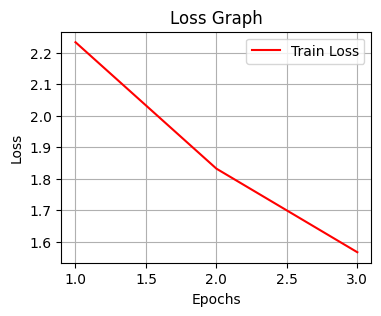

In [ ]:
# plot the losss curve
epochs = list(range(1, len(running_loss_history) + 1))

fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, running_loss_history , color='r')
plt.title('Loss Graph')
plt.legend(["Train Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)


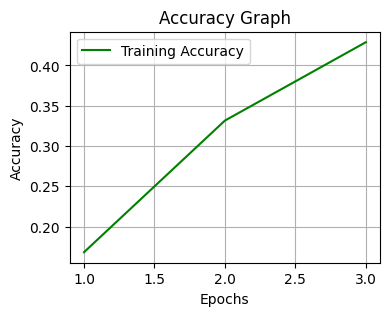

In [ ]:
# plot the accuracy curve
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, running_corrects_history , color='g')
plt.title('Accuracy Graph')
plt.legend(["Training Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_CNNnet.pth'
torch.save(model.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

## 5. Test the network on the test data

We have trained the network for several epochs over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

First step. Let us display an image from the test set to get familiar.



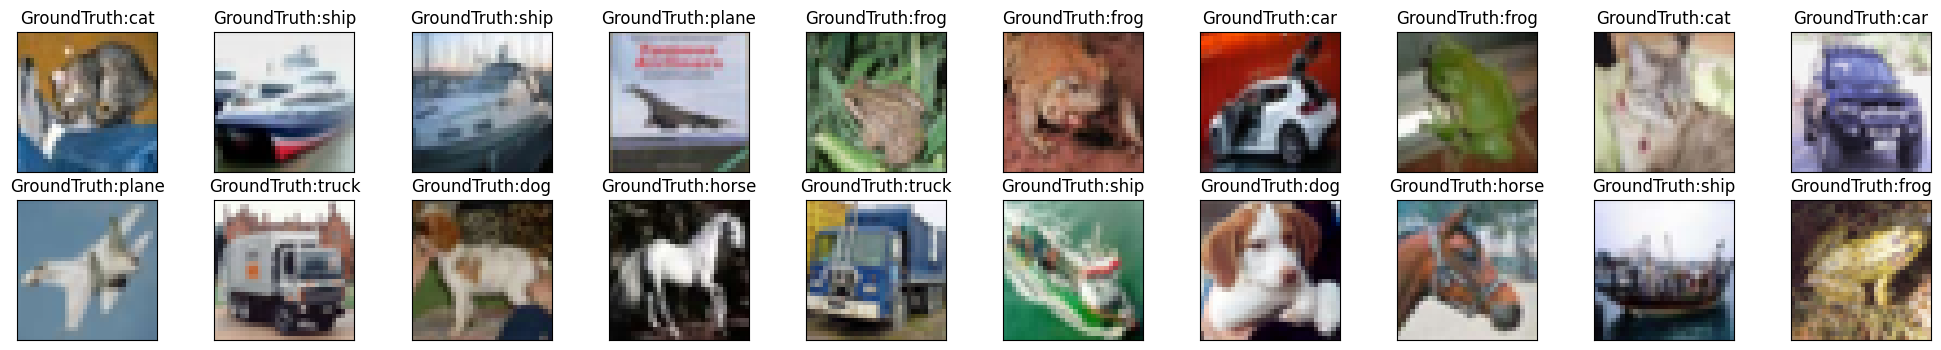

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our test_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title('GroundTruth:' + classes[labels[idx].item()])


load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so. You can skip this cell and run the next cell to assign our trained model to ``test_model``):



In [ ]:
# create a new model with the same CNNnet function
test_model = CNNnet().to(device)
print(test_model)
# load weights from our saved models
test_model.load_state_dict(torch.load(PATH))

CNNnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


<All keys matched successfully>

In [ ]:
# if you want to use the trained model directly, run this code
test_model = model

Let us see what the neural network thinks these examples above are:



In [ ]:
outputs = test_model(images.to(device))

The outputs are probabilities for the 10 classes.
The higher the probability for a class, the more the network
thinks that the image is of the particular class.



Accuracy of the network on the first batch of test images: 59 %


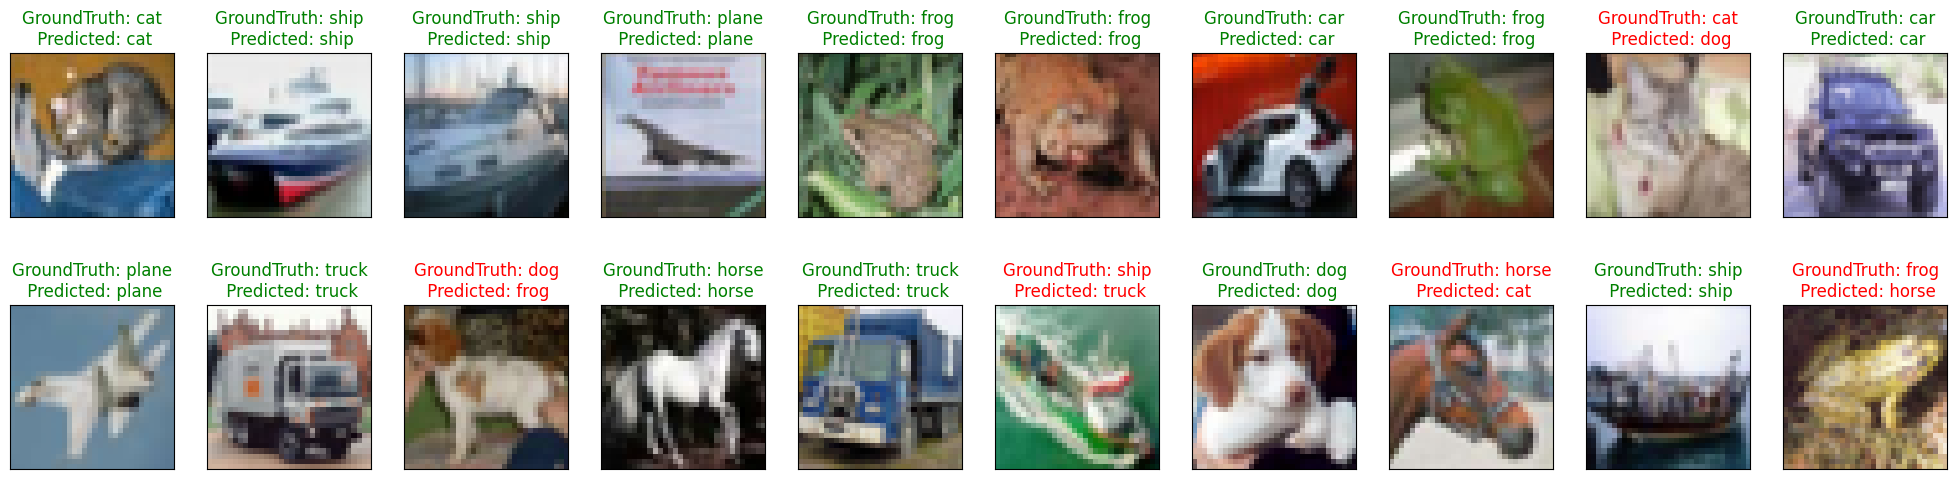

In [ ]:
_, predicted = torch.max(outputs, 1)
correct = 0
correct += (predicted == labels.to(device)).sum().item()
print(f'Accuracy of the network on the first batch of test images: {100 * correct // batch_size} %')

# show images
fig = plt.figure(figsize=(25, 6))
# We plot 20 images from our test_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title('GroundTruth: ' + classes[labels[idx].item()] + '\n Predicted: '+ classes[predicted[idx].item()], color=("green" if predicted[idx]==labels[idx] else "red"))


The results seem not bad.

We can proceed to look at how the network performs on the whole testing dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = test_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images after training for {total_epoch} epochs: {100 * correct // total} %')

Accuracy of the network on the 10000 test images after training for 10 epochs: 61 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = test_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.6 %
Accuracy for class: car   is 80.2 %
Accuracy for class: bird  is 41.7 %
Accuracy for class: cat   is 47.1 %
Accuracy for class: deer  is 58.5 %
Accuracy for class: dog   is 52.1 %
Accuracy for class: frog  is 72.8 %
Accuracy for class: horse is 61.2 %
Accuracy for class: ship  is 80.8 %
Accuracy for class: truck is 56.2 %


## Train a new model with Data Augmentation

In simple terms, Data Augmentation is simply creating fake data. You use the data in the existing train set to create variations of it. This does two things
- Increases the size of your training set
- Regularizes your network

Broadly, data augmentation in images involves changing the orientation of images, selecting a part of an image, randomly or otherwise. We discuss a few transforms here. However, a complete list of transforms can be found here.

### Data augmentation

In [ ]:
transform_train_augmented = transforms.Compose([
                                      # Randomly fLips the image w.r.t horizontal axis
                                      transforms.RandomHorizontalFlip(p=0.2),
                                      # Randomly rotates the image to a specified angel
                                      transforms.RandomRotation(10),
                                      # Randomly performs actions like zooms, change shear angles
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      # Randomly change the brightness, contrast, saturation and hue of an image
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      # comvert the image to tensor so that it can work with torch
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])


training_dataset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_augmented) # Data augmentation is only done on training images
training_loader_augmented = torch.utils.data.DataLoader(training_dataset_augmented, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [ ]:
print(len(training_dataset_augmented))
print(len(training_loader_augmented))

50000
1563


torch.Size([32, 3, 32, 32])


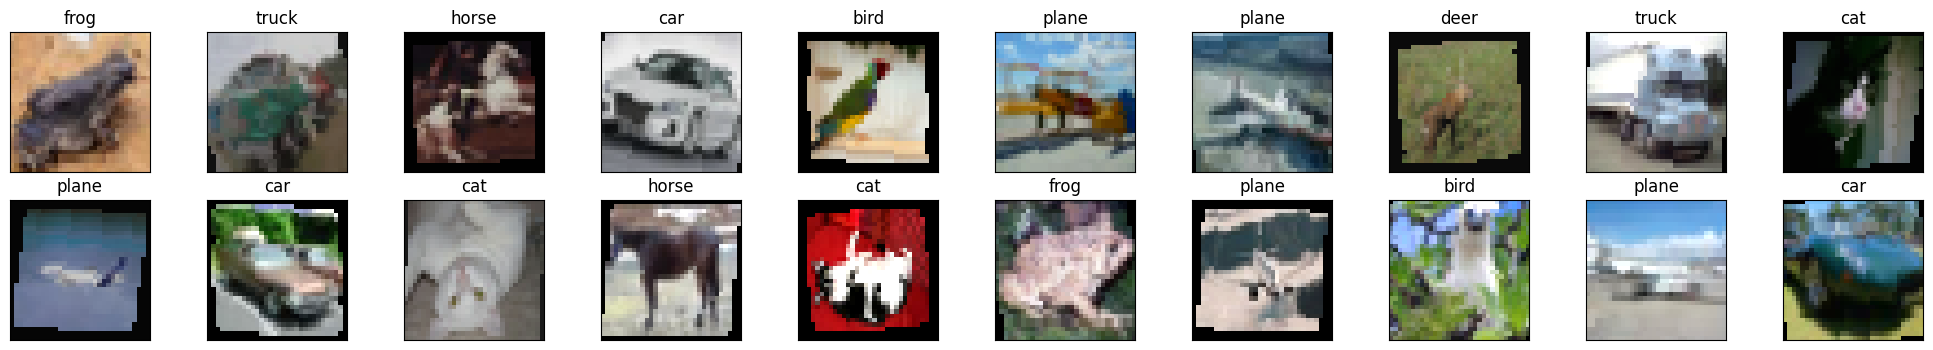

In [ ]:
# get some random training images
dataiter_augmented = iter(training_loader_augmented)
images_augmented, labels_augmented = next(dataiter_augmented)

# check batch size
print(images_augmented.shape)

# show images
fig = plt.figure(figsize=(25, 4))
# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images_augmented[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels_augmented[idx].item()])

### Create and train a new model

In [ ]:
model_augmented = CNNnet().to(device)
print(model_augmented)

CNNnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# create two empty lists to store loss and accuracy history
running_loss_history_augmented = []
running_corrects_history_augmented = []

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmented.parameters(), lr=0.001, momentum=0.9)

total_epoch = 10

# loop over the dataset multiple times
for epoch in range(total_epoch):
    running_loss = 0.0
    running_corrects = 0.0
    batch_running_loss = 0.0

    for i, data in enumerate(training_loader_augmented, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_augmented(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate accuracy and loss
        _, predicted = torch.max(outputs.data, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += (predicted == labels).sum().item() # calculating te accuracy by taking the sum of all the correct predictions in a batch.

        # print the loss after every 200 batches
        batch_running_loss += loss.item()
        if i % 200 == 199:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {batch_running_loss / 200:.3f}')
            batch_running_loss = 0.0

    epoch_loss = running_loss/len(training_loader_augmented)
    epoch_acc = running_corrects/ len(training_loader_augmented.dataset)

    running_loss_history_augmented.append(epoch_loss)
    running_corrects_history_augmented.append(epoch_acc)

    # print statistics
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc))

print('Finished Training')

[1,   200] loss: 2.303
[1,   400] loss: 2.299
[1,   600] loss: 2.293
[1,   800] loss: 2.279
[1,  1000] loss: 2.239
[1,  1200] loss: 2.159
[1,  1400] loss: 2.088
epoch : 1
training loss: 2.2170, acc 0.1640 
[2,   200] loss: 1.984
[2,   400] loss: 1.943
[2,   600] loss: 1.897
[2,   800] loss: 1.862
[2,  1000] loss: 1.829
[2,  1200] loss: 1.791
[2,  1400] loss: 1.776
epoch : 2
training loss: 1.8550, acc 0.3249 
[3,   200] loss: 1.736
[3,   400] loss: 1.694
[3,   600] loss: 1.688
[3,   800] loss: 1.685
[3,  1000] loss: 1.657
[3,  1200] loss: 1.640
[3,  1400] loss: 1.631
epoch : 3
training loss: 1.6717, acc 0.3922 
[4,   200] loss: 1.598
[4,   400] loss: 1.604
[4,   600] loss: 1.616
[4,   800] loss: 1.596
[4,  1000] loss: 1.567
[4,  1200] loss: 1.569
[4,  1400] loss: 1.567
epoch : 4
training loss: 1.5848, acc 0.4223 
[5,   200] loss: 1.528
[5,   400] loss: 1.553
[5,   600] loss: 1.528
[5,   800] loss: 1.522
[5,  1000] loss: 1.506
[5,  1200] loss: 1.519
[5,  1400] loss: 1.503
epoch : 5
train

### Visualize the loss and accuracy

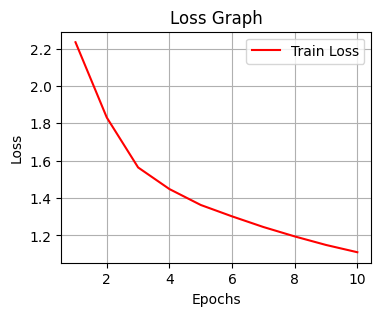

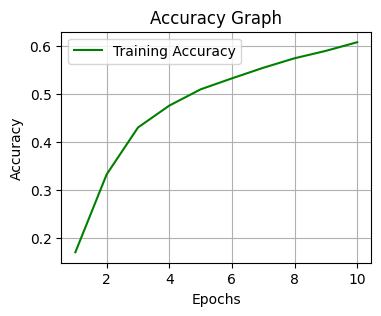

In [ ]:
# plot the losss curve
epochs = list(range(1, len(running_loss_history) + 1))
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, running_loss_history , color='r')
plt.title('Loss Graph')
plt.legend(["Train Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

# plot the accuracy curve
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(epochs, running_corrects_history , color='g')
plt.title('Accuracy Graph')
plt.legend(["Training Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)


### Evaluate the performance

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model_augmented(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images with data augmentation after training for {total_epoch} epochs: {100 * correct // total} %')

Accuracy of the network on the 10000 test images with data augmentation after training for 10 epochs: 57 %


# Reference:
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://medium.com/swlh/how-data-augmentation-improves-your-cnn-performance-an-experiment-in-pytorch-and-torchvision-e5fb36d038fb

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device, in_channels=1):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)

        # This a batch normalization layer. it will improve training stability and convergence.
        # typically applied to individual layers after a linear transformation and before the activation function.
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)

        # Linear Layer for Mean (mu) of Latent Space
        self.linear_mu = nn.Linear(128, latent_dims)
        # Linear Layer for Log-Variance (logvar) of Latent Space
        self.linear_logvar = nn.Linear(128, latent_dims)
        self.relu = nn.LeakyReLU()

        # variable to store Kullback–Leibler (KL) divergence
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))

        # 1) The encoder produces a mean value (mu) for each dimension of the latent space, which represents the center of a Gaussian distribution in that dimension.
        mu =  self.linear_mu(x)
        # 2) The encoder also produces a log-variance value (logvar) for each dimension, which is often treated as a learned offset to the Gaussian's log-variance.
        logvar = self.linear_logvar(x)
        # It's common to work with the logarithm of the variance (log-variance) rather than the standard deviation (sigma) directly
        # reason 1: the log-variance can take on any real value, which is important because it allows the model to capture both small and large variances effectively.
        # reason 2: optimization algorithms like gradient descent often beneficial to work with quantities that are centered around zero. Taking the logarithm helps center the values around zero and avoids issues with extremely small or large numbers.

        # 3) During the sampling process (when generating latent vectors), you exponentiate the logvar to obtain the standard deviation (sigma) of the Gaussian distribution.
        std = torch.exp(0.5 *logvar)

        # 4) You then sample from this Gaussian distribution with mean (mu) and standard deviation (sigma) to generate a latent vector.
        # a latent vector is sampled from this probability distribution
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # add an auxillary loss that penalizes the distribution P(z|x) for being to far from the N(0,1)
        # Kullback–Leibler (KL) divergence. The KL divergence is a metric used to measure the distance between two probability distribution: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8
        # reason 1: we need this loss to train the encoder network since gradients cannot flow through sampling (which is a non-differentiable operation).
        # reason 2: we can encourage the latent vectors to occupy a more centralized and uniform location by penalizing the KL divergence
        # we could also approximate KL with monte-carlo simulation. The code is shown below.

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return z